### Import needed libraries

In [1]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import lfilter
from scipy.io import wavfile
from scipy import signal
from IPython import display

### Define a function for plotting

In [2]:
def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

In [3]:
# import the noisy audio
samplerate, data=wavfile.read("55099.wav")

display.display(display.Audio(data=data, rate=samplerate))

/tmp/ipykernel_1141/2056385215.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data=wavfile.read("55099.wav")


In [4]:
print((samplerate))

44100


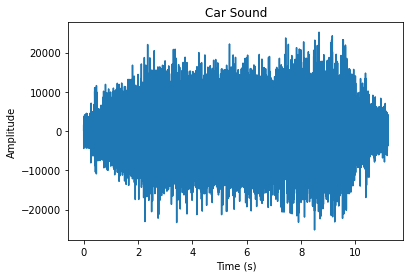

In [5]:
# Parameters    
period = 1/samplerate                             # T = 1/Sr and samplerate is data points per second       
number_of_samples = len(data)          

duration = 1/samplerate * number_of_samples      # duration is length of created sample
ti = np.arange(0, duration, 1/samplerate)

plt.plot(ti, data)
plt.title("Car Sound")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show()

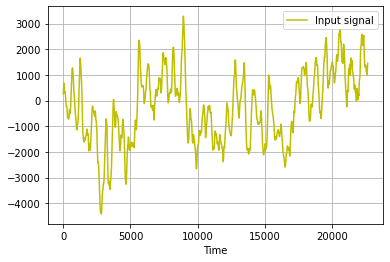

In [6]:
# Plot signal to the notebook
plot_to_notebook(ti,data,1000)

## FIR filter algorithm

### CPU implementation

CPU execution time:  0.20514512062072754


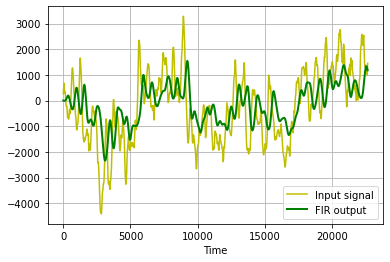

In [7]:
# define the coefficients
coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

start_time = time.time()                               # use time.time() to measure elapsed time
fir_output = lfilter(coeffs,70e3,data)                 # FIR filter
stop_time = time.time()
CPU_time = stop_time - start_time
print('CPU execution time: ',CPU_time)

# Plot the result to notebook
plot_to_notebook(ti,data,1000,out_signal=fir_output)

display.display(display.Audio(data=fir_output, rate=samplerate))

### FPGA implementation

In [8]:
# Load the overlay
overlay = Overlay('FIR_filter.bit')

# Load the FIR DMA
dma = overlay.filter.fir_dma

FPGA execution time:  0.007742643356323242
FPGA is 26.49548883756736 faster than CPU


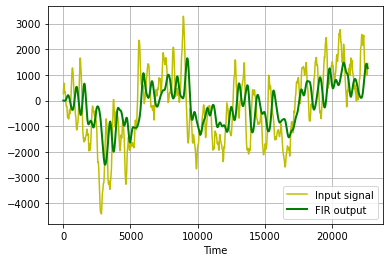

In [9]:
# The pynq.allocate function is used to allocate memory that will be used by IP in the programmable logic.

# Allocate buffers for the input and output signals
in_buffer = allocate(shape=(len(data),),dtype=np.int32)
out_buffer = allocate(shape=(len(data),),dtype=np.int32)

# Copy the input signal to the in_buffer
np.copyto(in_buffer,data)

# Trigger the DMA transfer and wait for the result
start_time = time.time()                        # use time.time() to measure elapsed time
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
FPGA_time = stop_time-start_time


print('FPGA execution time: ',FPGA_time)
print(f'FPGA is {CPU_time / FPGA_time} faster than CPU')


# Plot to the notebook
plot_to_notebook(ti,data,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

display.display(display.Audio(data=out_buffer, rate=samplerate))